# Monte Carlo Analysis
This notebook demonstrates a Monte Carlo analysis of the performance of the solvers ALGAMES and iLQGames.

In [2]:
using ALGAMES
using BenchmarkTools
using LinearAlgebra
using StaticArrays
using TrajectoryOptimization
const TO = TrajectoryOptimization;

### Define the dynamics model of the game.

In [3]:
struct InertialUnicycleGame{T} <: AbstractGameModel
    n::Int  # Number of states
    m::Int  # Number of controls
    mp::T
    pu::Vector{Vector{Int}} # Indices of the each player's controls
    px::Vector{Vector{Int}} # Indices of the each player's x and y positions
    p::Int  # Number of players
end
InertialUnicycleGame() = InertialUnicycleGame(
    12,
    6,
    1.0,
    [[1,2],[3,4],[5,6]],
    [[1,2],[5,6],[9,10]],
    3)
Base.size(::InertialUnicycleGame) = 12,6,[[1,2],[3,4],[5,6]],3 # n,m,pu,p

### Instantiate dynamics model

In [4]:
model = InertialUnicycleGame()
n,m,pu,p = size(model)
T = Float64
px = model.px

# We use the unicycle dynamics for each player. 
# State   x = [px1, py1, θ1, v1, px2, py2, θ2, v2, px3, py3, θ3, v3] 
# Control u = [θ1, v1, θ2, v2, θ3, v3]
# px1 = x position of player 1 
# py1 = y position of player 1 
# θ1 = orientation of player 1 
# v1 = x velocity of player 1 

function TO.dynamics(model::InertialUnicycleGame, x, u) # Non memory allocating dynamics
    qd1 = @SVector [cos(x[3]), sin(x[3])]
    qd1 *= x[4]
    qd2 = @SVector [cos(x[7]), sin(x[7])]
    qd2 *= x[8]
    qd3 = @SVector [cos(x[11]), sin(x[11])]
    qd3 *= x[12]
    qdd1 = u[ @SVector [1,2] ]
    qdd2 = u[ @SVector [3,4] ]
    qdd3 = u[ @SVector [5,6] ]
    return [qd1; qdd1; qd2; qdd2; qd3; qdd3]
end;

### Discretization of the trajectories

In [5]:
tf = 3.0  # final time
N = 21    # number of knot points
dt = tf / (N-1); # time step duration

### Initial and final state definition

In [6]:
# Define initial and final states (be sure to use Static Vectors!)
x0 = @SVector  [
               -0.80, -0.05,  0.00, 0.90, #player 1 x,y,θ,v
               -1.00, -0.05,  0.00, 0.90, #player 2 x,y,θ,v
               -0.90, -0.30, pi/12, 0.95, #player 3 x,y,θ,v
                ]
xf = @SVector [
                1.10, -0.05,  0.00, 0.90, #player 1 x,y,θ,v
                0.70, -0.05,  0.00, 0.90, #player 2 x,y,θ,v
                0.90, -0.05,  0.00, 0.90, #player 3 x,y,θ,v
               ];

### Define players objective functions

In [7]:
# Define quadratic costs
diag_Q1 = @SVector [ # Player 1 state cost
    0., 10., 1., 1.,
    0., 0., 0., 0.,
    0., 0., 0., 0.]
diag_Q2 = @SVector [ # Player 2 state cost
    0., 0., 0., 0.,
    0., 10., 1., 1.,
    0., 0., 0., 0.]
diag_Q3 = @SVector [ # Player 3 state cost
    0., 0., 0., 0.,
    0., 0., 0., 0.,
    0., 10., 1., 1.]

# Players stage state costs
Q = [0.1*Diagonal(diag_Q1), 
     0.1*Diagonal(diag_Q2),
     0.1*Diagonal(diag_Q3)]

# Players final state costs
Qf = [1.0*Diagonal(diag_Q1),
      1.0*Diagonal(diag_Q2),
      1.0*Diagonal(diag_Q3)]

# Players controls costs
R = [0.1*Diagonal(@SVector ones(length(pu[1]))),
     0.1*Diagonal(@SVector ones(length(pu[2]))),
     0.1*Diagonal(@SVector ones(length(pu[3]))),
    ]

# Players objectives
obj = [LQRObjective(Q[i],R[i],Qf[i],xf,N) for i=1:p];

### Define the initial trajectory

In [8]:
xs = SVector{n}(zeros(n))
us = SVector{m}(zeros(m))
Z = [KnotPoint(xs,us,dt) for k = 1:N]
Z[end] = KnotPoint(xs,m);

### Build the ramp merging scenario

In [9]:
# Actors 
actor_radius = 0.08
actors_radii = [actor_radius for i=1:p]
actors_types = [:car, :car, :car]

#Scene
road_length = 2.20
road_width = 0.34
ramp_length = 1.2
ramp_angle = pi/12

# Build scenario
scenario = MergingScenario(
        road_length, road_width, ramp_length, 
        ramp_angle, car_radii, actors_types);

UndefVarError: UndefVarError: car_radii not defined

### Define constraints of the problem

In [10]:
# Create constraint sets
algames_conSet = ConstraintSet(n,m,N)
ilqgames_conSet = ConstraintSet(n,m,N)
con_inds = 2:N # Indices where the constraints will be applied

# Add collision avoidance constraints
add_collision_avoidance(algames_conSet, actors_radii, px, p, con_inds)
add_collision_avoidance(ilqgames_conSet, actors_radii, px, p, con_inds)

# Add scenario specific constraints (road boundaries)
add_scenario_constraints(algames_conSet, scenario, px, con_inds; constraint_type=:constraint)
add_scenario_constraints(ilqgames_conSet, scenario, px, con_inds; constraint_type=:constraint);

UndefVarError: UndefVarError: scenario not defined

### Define the problem we will be solving

In [11]:
algames_prob = GameProblem(model, obj, algames_conSet, x0, xf, Z, N, tf)
ilqgames_prob = GameProblem(model, obj, ilqgames_conSet, x0, xf, Z, N, tf);

### Build ALGAMES  and iLQGames solvers

In [15]:
algames_opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10,
    log_level=ALGAMES.Logging.Warn)
algames_solver = DirectGamesSolver(algames_prob, algames_opts)

ilqgames_opts = PenaltyiLQGamesSolverOptions{T}(
    iterations=200,
    gradient_norm_tolerance=1e-2,
    cost_tolerance=1e-4,
    iterations_linesearch=5,
    line_search_lower_bound=0.0,
    line_search_upper_bound=0.02,
    log_level=ALGAMES.Logging.Warn)
ilqgames_solver = PenaltyiLQGamesSolver(ilqgames_prob, ilqgames_opts)
pen = ones(length(ilqgames_solver.constraints))*100.0
set_penalty!(ilqgames_solver, pen)

### Solve the nominal problems 

In [16]:
@time solve!(algames_solver);

  0.010583 seconds (5.28 k allocations: 4.759 MiB)


In [17]:
@time solve!(ilqgames_solver);

  0.066582 seconds (193.24 k allocations: 55.331 MiB, 46.26% gc time)


### Build the Monte Carlo Sampler for each solver
We can change the number of samples (here we've chosen 200) to reduce the compute time. 

In [18]:
# Define a noise that will be added to the initial state of the system x0. 
# By sampling x0 randomly we generate a class of similar dynamic games. 
# In this case, we add noise to the initial speeds, positions and orientations of the vehicles.
state_noise = @SVector [ # Uniform noise around x0
    0.06, 0.06, 2*pi/72, 0.05,
    0.06, 0.06, 2*pi/72, 0.05,
    0.06, 0.06, 2*pi/72, 0.05]
opts_monte_carlo = MonteCarloSamplerOptions{n,T}(
    noise=state_noise, # noise added to the initial state 
    iterations=200) # number of Monte Carlo samples 

algames_sampler = MonteCarloSampler(algames_solver, opts_monte_carlo)
ilqgames_sampler = MonteCarloSampler(ilqgames_solver, opts_monte_carlo);

### Sample and store the results for the Monte Carlo analysis.

In [19]:
monte_carlo_sampling(algames_sampler)
monte_carlo_sampling(ilqgames_sampler)

### Plot the histograms compiling the results for ALGAMES

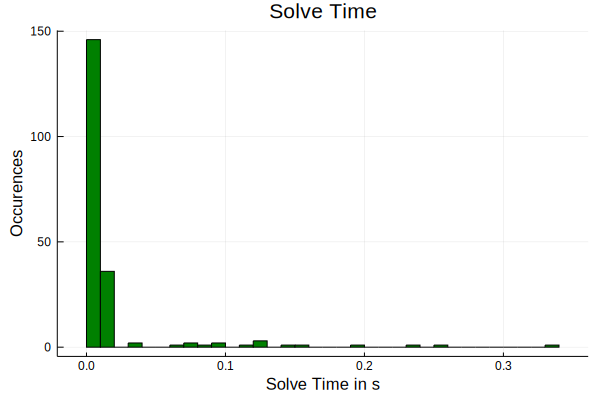

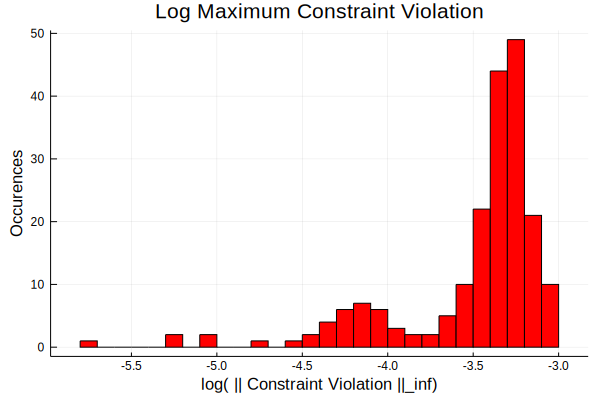

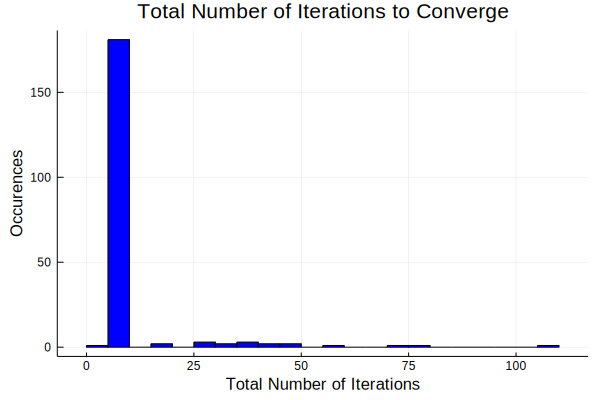

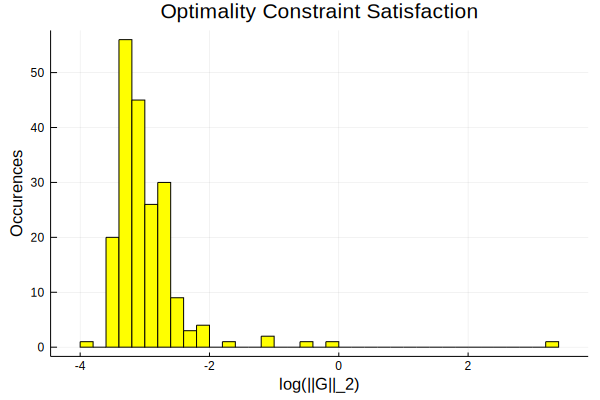

In [20]:
# Time required to solve the problem
visualize_solve_time(algames_sampler; save=false)

# Maximum constraint violation
visualize_cmax(algames_sampler; save=false)

# Number of iterations (Newton step for ALGAMES, Riccati backwardpass for iLQGames)
visualize_iterations_total(algames_sampler; save=false)

# Optimality constraint satisfaction 
visualize_optimality_merit(algames_sampler; save=false)

### Plot the histograms compiling the results for ilQGames

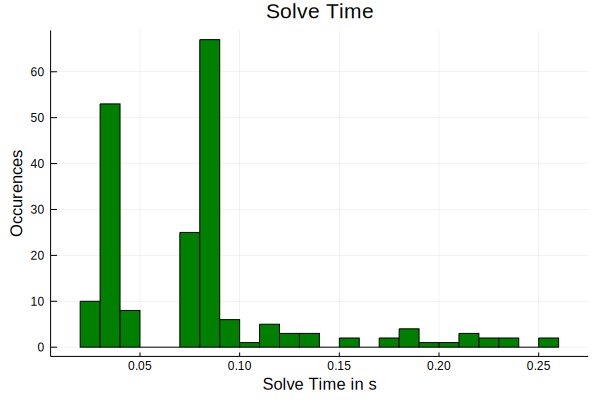

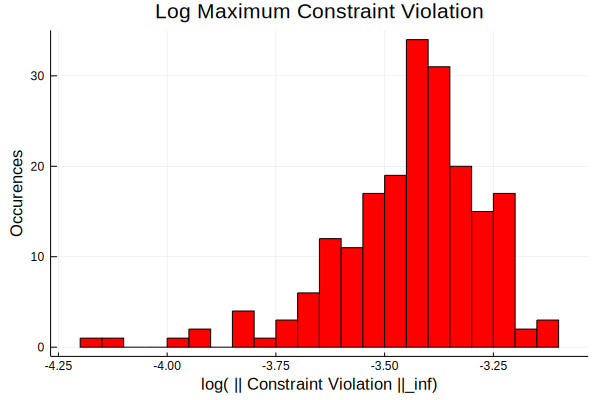

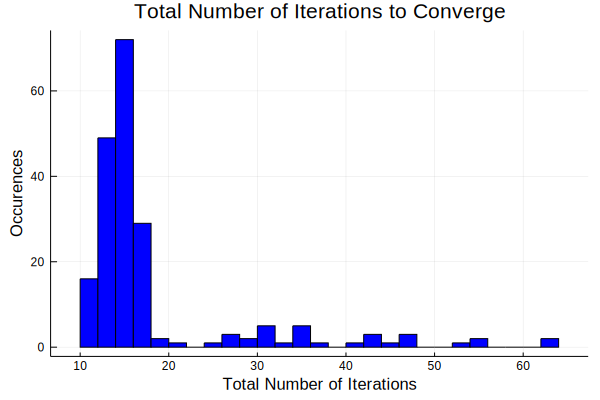

In [21]:
# Time required to solve the problem
visualize_solve_time(ilqgames_sampler; save=false)

# Maximum constraint violation
visualize_cmax(ilqgames_sampler; save=false)

# Number of iterations (Newton step for ALGAMES, Riccati backwardpass for iLQGames)
visualize_iterations_total(ilqgames_sampler; save=false)